<a href="https://colab.research.google.com/github/Sim98B/ShroomVision/blob/main/SV4/ShroomVision4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  print(f"torch: {torch.__version__}")
  import torchvision
  print(f"torchvision: {torchvision.__version__}")
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install torch torchvision
  import torch
  import torchvision

import os
import zipfile
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

!git clone https://github.com/Sim98B/ShroomVision
!mv ShroomVision/Modules/Libraries .

from Libraries import data, utils, model_ops

shutil.rmtree("ShroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
Cloning into 'ShroomVision'...
remote: Enumerating objects: 2601, done.
remote: Counting objects: 100% (1054/1054), done.
remote: Compressing objects: 100% (732/732), done.
remote: Total 2601 (delta 334), reused 949 (delta 288), pack-reused 1547
Receiving objects: 100% (2601/2601), 258.94 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (470/470), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
data_path = data.download_data(source = "https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip",
                               remove_source = True)

train_dir = data_path.joinpath("train_data")
val_dir = data_path.joinpath("val_data")
test_dir = data_path.joinpath("test_data")
data_path

[INFO] Did not find data directory, creating one...
[INFO] Downloading SV4_data.zip from https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip...
[INFO] Unzipping SV4_data.zip data...


PosixPath('data/SV4_data')

In [4]:
data.inspect_dir(data_path)

There are 3 directory/ies and 0 file/s in data/SV4_data
There are 4 directory/ies and 0 file/s in data/SV4_data/test_data
There are 0 directory/ies and 51 file/s in data/SV4_data/test_data/amanita_vaginata
There are 0 directory/ies and 111 file/s in data/SV4_data/test_data/boletus_edulis
There are 0 directory/ies and 171 file/s in data/SV4_data/test_data/amanita_muscaria
There are 0 directory/ies and 39 file/s in data/SV4_data/test_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/val_data
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/amanita_vaginata
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/boletus_edulis
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/amanita_muscaria
There are 0 directory/ies and 64 file/s in data/SV4_data/val_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/train_data
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita

In [5]:
data.plot_random_images(data_path = data_path,
                        target_folder = "train_data")

In [6]:
sv4_transformer = transforms.Compose([transforms.Resize(size=(64, 64)),
                                 transforms.ToTensor()])

train_loader, class_names  = data.dataloader(train_dir, transformer = sv4_transformer, bs = 32, shuffle = True)
val_loader, _  = data.dataloader(val_dir, transformer = sv4_transformer, bs = 32, shuffle = False)
test_loader, _  = data.dataloader(test_dir, transformer = sv4_transformer, bs = 32, shuffle = False)

train_loader, val_loader, test_loader, class_names

In [ ]:
data.plot_dataloader_img(dataloader = train_loader,
                         n_images = 5,
                         classes = class_names)

In [ ]:
utils.set_seed()
baseline = utils.linear_baseline(input_height = 64,
                                 input_width = 64,
                                 color_channels = 3,
                                 output_shape = 4,
                                 num_layers = 3,
                                 num_neurons = 10).to(device)
baseline

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline.parameters(),
                             lr=0.001)

In [ ]:
start = timer()

baseline_results = model_ops.train(model = baseline,
                                   train_dataloader = train_loader,
                                   test_dataloader = val_loader,
                                   loss_function = loss_fn,
                                   optimizer = optimizer,
                                   metric = "accuracy",
                                   epochs = 20,
                                   device = "cpu",
                                   verbose = 2)
end = timer()

utils.delta_time(start, end)

In [ ]:
utils.plot_model_performance(results_dict = baseline_results,
                             fig_size = (15, 5),
                             metric_name = "Accuracy",
                             title = "Baseline model performance")

In [ ]:
baseline_val_pred = model_ops.make_predictions(model = baseline,
                                               test_dataloader = val_loader)

utils.plot_confusion_matrix(y_true = baseline_val_pred["true_labels"],
                            y_pred = baseline_val_pred["predictions"],
                            class_names = class_names,
                            norm = "all",
                            title = "Baseline performance on validation set")

In [ ]:
sv4_transformer_augmentation = transforms.Compose([transforms.Resize(size=(64, 64)),
                                                   transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                                   transforms.ToTensor()])

train_loader_augmented, class_names  = data.dataloader(train_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = True)
val_loader_augmented, _  = data.dataloader(val_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = False)
test_loader_augmented, _  = data.dataloader(test_dir, transformer = sv4_transformer_augmentation, bs = 32, shuffle = False)

train_loader_augmented, val_loader_augmented, test_loader_augmented, class_names

In [ ]:
data.plot_dataloader_img(dataloader = train_loader_augmented,
                         n_images = 5,
                         classes = class_names)

In [ ]:
utils.set_seed()
baseline_augmentation = utils.linear_baseline(input_height = 64,
                                              input_width = 64,
                                              color_channels = 3,
                                              output_shape = 4,
                                              num_layers = 3,
                                              num_neurons = 10).to(device)
baseline_augmentation

In [74]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_augmentation.parameters(),
                             lr=0.001)

In [75]:
start = timer()

baseline_augmentation_results = model_ops.train(model = baseline_augmentation,
                                                train_dataloader = train_loader_augmented,
                                                test_dataloader = val_loader_augmented,
                                                loss_function = loss_fn,
                                                optimizer = optimizer,
                                                metric = "accuracy",
                                                epochs = 20,
                                                device = "cpu",
                                                verbose = 2)
end = timer()

utils.delta_time(start, end)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: Train Loss: 1.395 | Train Accuracy: 26.75% | Test Loss: 1.374 | Test Accuracy: 30.86%
Epoch 02: Train Loss: 1.351 | Train Accuracy: 32.62% | Test Loss: 1.336 | Test Accuracy: 35.16%
Epoch 03: Train Loss: 1.328 | Train Accuracy: 34.88% | Test Loss: 1.312 | Test Accuracy: 36.72%
Epoch 04: Train Loss: 1.303 | Train Accuracy: 37.38% | Test Loss: 1.295 | Test Accuracy: 36.33%
Epoch 05: Train Loss: 1.266 | Train Accuracy: 39.38% | Test Loss: 1.298 | Test Accuracy: 37.11%
Epoch 06: Train Loss: 1.240 | Train Accuracy: 40.25% | Test Loss: 1.339 | Test Accuracy: 35.16%
Epoch 07: Train Loss: 1.203 | Train Accuracy: 43.88% | Test Loss: 1.316 | Test Accuracy: 35.55%
Epoch 08: Train Loss: 1.163 | Train Accuracy: 46.88% | Test Loss: 1.296 | Test Accuracy: 39.45%
Epoch 09: Train Loss: 1.126 | Train Accuracy: 48.75% | Test Loss: 1.300 | Test Accuracy: 40.23%
Epoch 10: Train Loss: 1.093 | Train Accuracy: 49.00% | Test Loss: 1.299 | Test Accuracy: 41.02%
Epoch 11: Train Loss: 1.059 | Train Accu

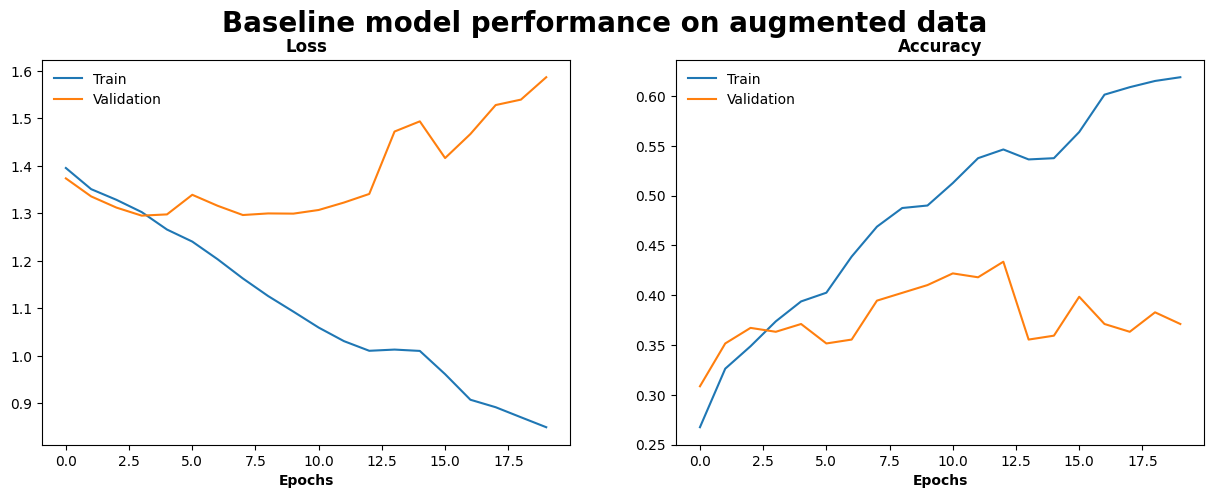

In [76]:
utils.plot_model_performance(results_dict = baseline_augmentation_results,
                             fig_size = (15, 5),
                             metric_name = "Accuracy",
                             title = "Baseline model performance on augmented data")

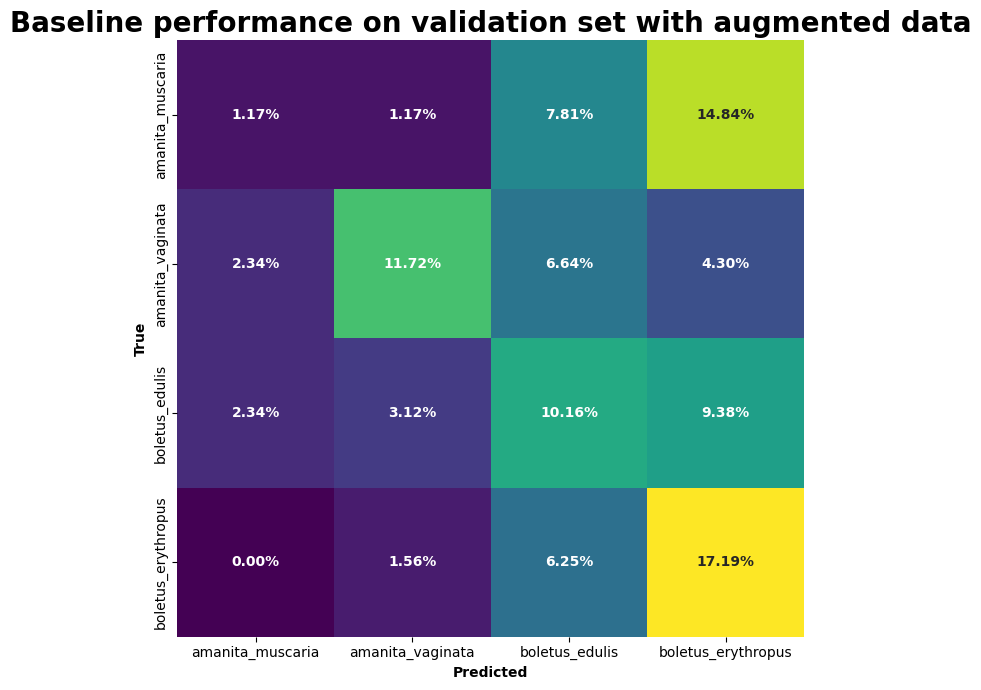

In [77]:
baseline_val_augmented_pred = model_ops.make_predictions(model = baseline_augmentation,
                                                         test_dataloader = val_loader_augmented)

utils.plot_confusion_matrix(y_true = baseline_val_augmented_pred["true_labels"],
                            y_pred = baseline_val_augmented_pred["predictions"],
                            class_names = class_names,
                            norm = "all",
                            title = "Baseline performance on validation set with augmented data")

In [ ]:
def compare_models(model1_results: dict,
                   model2_results: dict,
                   model1_pred):